# Dependent Bandit Experiment II

Implementation of the 2nd dependent bandit experiment in the [Learning to Reinforcement Learn](https://arxiv.org/abs/1611.05763) paper. (See section 3.1.3)

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cpu')

seed = 123
torch.manual_seed(seed);
np.random.seed(seed);

### 1 Helper Functions

In [4]:
def test(agent):
    env = DependentBandit()
    state = env.reset()
    
    done = False
    total_reward = 0
    c = torch.zeros(1, 48).to(device)
    h = torch.zeros(1, 48).to(device)
    reward = 0
    action = 0
    
    while not done:
        state = torch.tensor(state).to(device)
        pi, _, _, h, c = agent(state, reward, action, h, c)
        action = pi.sample()
        next_state, reward, done, _ = env.step(action.item())
        state = next_state
        total_reward += reward
        
    return total_reward

In [5]:
def plot(episode, test_rewards):
    clear_output(True)
    plt.figure(figsize=(8,5))
    plt.plot(test_rewards, color='red')
    plt.title('episode: {}'.format(episode))
    plt.xlabel('episode (*100)')
    plt.ylabel('average reward')
    plt.grid(True)
    plt.show()

In [6]:
def onehot_action(action, size=11):
    oh = np.zeros(size)
    oh[action] = 1.0
    return oh

In [7]:
def onehot_reward(reward, action, size=12):
    oh = np.zeros(size)
    if action == 10:
        oh[int(reward*10 - 1)] = 1.0
    else:
        if reward == 1:
            oh[10] = 1.0
        else:
            oh[11] = 1.0
    return oh

### 2 Environment

The 2nd dependent bandit environment.

In [8]:
class DependentBandit():
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.timestep = 0
        self.target = np.random.randint(10)
        return self.timestep
    
    def step(self, action):
        self.timestep += 1
        done = False
        
        if action == 10:
            reward = (self.target+1)/10.0
        elif action == self.target:
            reward = 5.0
        else:
            reward = 1.0
            
        if self.timestep == 5: done = True
        
        return self.timestep, reward, done, _

### 3 Meta RL Agent

An RNN, a general purpose computer, that performs meta learning.

In [9]:
class MetaRLAgent(nn.Module):
    
    def __init__(self, num_inputs, num_outputs):
        super(MetaRLAgent, self).__init__()
        
        self.lstm = nn.LSTMCell(num_inputs, 48)
        self.fc_pol = nn.Linear(48, num_outputs)
        self.fc_val = nn.Linear(48, 1)
        
        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)
        nn.init.xavier_uniform_(self.fc_pol.weight)
        nn.init.zeros_(self.fc_pol.bias)
        nn.init.xavier_uniform_(self.fc_val.weight)
        nn.init.zeros_(self.fc_val.bias)
        
    def forward(self, s, r, a, h, c):
        inp = np.array([onehot_action(a), onehot_reward(r, a), np.array([s])])
        inp = np.concatenate(inp, axis=0)
        inp = torch.tensor(inp, dtype=torch.float32)
        inp = torch.unsqueeze(inp, dim=0).to(device)
        
        h, c = self.lstm(inp, (h, c))
        
        prob = F.softmax(self.fc_pol(h), dim=1)
        pi = Categorical(prob)
        
        v = self.fc_val(h)
        
        return pi, prob, v, h, c

### 4 Training

Below is a **single** A3C worker whose input is augmented for meta reinforcement learning. The agent learns the optimal long-run strategy which is sampling the informative arm once and then exploiting the high-valued target arm. It gets a reward between 0 and 1 in the first sample and then gets 4 5s consecutively which makes a total reward of **20.X**.

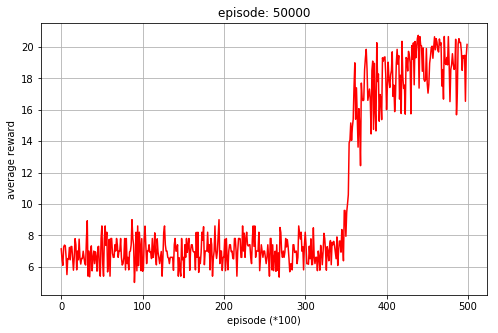

Rewards: [20.5, 20.2, 20.5, 20.8, 21.0, 17.0, 20.4, 20.6, 20.3, 20.3]
Average: 20.160000000000004


In [10]:
env = DependentBandit()

num_inputs = 24
num_outputs = 11
agent = MetaRLAgent(num_inputs, num_outputs).to(device)
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-3)

episode = 0
total_episodes = 50000
discount = 0.8

avg_test_rewards = []

while episode < total_episodes:
    
    batch_log_pis = []
    batch_rewards = []
    batch_baselines = []
    batch_entropies = []

    c = torch.zeros(1, 48).to(device)
    h = torch.zeros(1, 48).to(device)
    done = False
    state = env.reset()
    reward = 0
    action = 0
        
    while not done:
        
        state = torch.tensor(state).to(device)
        
        pi, prob, v, h, c = agent(state, reward, action, h, c)
        action = pi.sample()
        
        next_state, reward, done, _ = env.step(action.item())
        
        reward = torch.tensor([[reward]])
        log_pi = pi.log_prob(action)
        
        batch_log_pis.append(log_pi)
        batch_rewards.append(reward.to(device))
        batch_baselines.append(v)
        batch_entropies.append(-(torch.log(prob) * prob).sum(dim=1))
        
        state = next_state

    
    target_value = torch.tensor([[0.0]]).to(device)
    
    batch_target_values = []
    for reward in reversed(batch_rewards):
        target_value = reward + discount * target_value
        batch_target_values.append(target_value)
        
    batch_target_values.reverse()
    
    batch_log_pis = torch.cat(batch_log_pis)
    batch_target_values = torch.cat(batch_target_values).detach()
    batch_baselines = torch.cat(batch_baselines)
    batch_entropies = torch.cat(batch_entropies)
    
    batch_advantages = batch_target_values - batch_baselines
    
    policy_loss = -(batch_log_pis * batch_advantages.detach()).mean()
    value_loss = 0.05 * (batch_advantages.pow(2)).mean()
    entropy_loss = -0.05 * batch_entropies.mean()
    
    loss = policy_loss + value_loss + entropy_loss
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
    optimizer.step()
    
    episode += 1
    if episode % 100 == 0:
        rewards = [test(agent) for _ in range(10)]
        avg_test_rewards.append(np.mean(rewards))
        plot(episode, avg_test_rewards)
        print('Rewards: {}'.format(rewards))
        print('Average: {}'.format(np.mean(rewards)))